This is a short version of detection of bacteria in sample images obtained from Darkfield Microscopy.

# Importing Relevant Libraries

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time

import os
import os.path
from pathlib import Path
import glob

from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
import imageio
from IPython.display import Image
import matplotlib.image as mpimg
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import zipfile
from io import BytesIO
from nibabel import FileHolder
from nibabel.analyze import AnalyzeImage
import PIL
from IPython import display
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import data, io, filters
import skimage

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN,\
LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D,Reshape, Conv2DTranspose, LeakyReLU, ReLU
from keras import models
from keras import layers
import tensorflow as tf
from keras.applications import vgg16, vgg19, inception_resnet_v2
from keras import backend as K
from keras.utils.vis_utils import plot_model 
from keras.datasets import mnist
import keras

from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

# PATHS


In [26]:
bact_path = Path("images")
mask_path = Path("masks")
bact_png = list(bact_path.glob(r"*.png"))
mask_png = list(mask_path.glob(r"*.png"))
bact_series = pd.Series(bact_png, name= "Bacteria").astype(str)
mask_series = pd.Series(mask_png, name = "Mask").astype(str)
df = pd.concat([bact_series, mask_series], axis=1)

# Visualization

In [27]:
def simple_reading(image):
    r_im = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)

    return r_im

In [28]:
def gray_reading(image):
    gray_im = cv2.cvtColor(cv2.imread(image, cv2.COLOR_BGR2GRAY))

    return gray_im

In [51]:
def threshold_reading(image):
    _, thres_im = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)

    return thres_im

In [30]:
def adaptive_reading(image):
    r_im = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)
    adap_im = cv2.adaptiveThreshold(r_im, 20, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 2)

    return adap_im

In [31]:
def layers_reading(image, mask):
    r_im = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    r_mask = cv2.cvtColor(cv2.imread(mask), cv2.COLOR_BGR2GRAY)

    c_main = r_im.copy()
    c_main[r_mask == 1] = [255, 0, 0]
    c_main[r_mask == 2] = [0, 0, 255]

    c_main_2 = r_im.copy()
    b_im = cv2.addWeighted(c_main, 0.5, c_main_2, 0.5, 0, c_main_2)

    return b_im

# Modeling

In [32]:
im_list = []
transform_list = []

for im_x, mask_x in zip(df.Bacteria.values, df.Mask.values):
    r_im = simple_reading(im_x)
    transform_im = layers_reading(im_x, mask_x)

    resized_im = cv2.resize(r_im, (180,180))
    resized_transform = cv2.resize(transform_im, (180,180))

    im_list.append(resized_im)
    transform_list.append(resized_transform)





Text(0.5, 1.0, 'ORIGINAL')

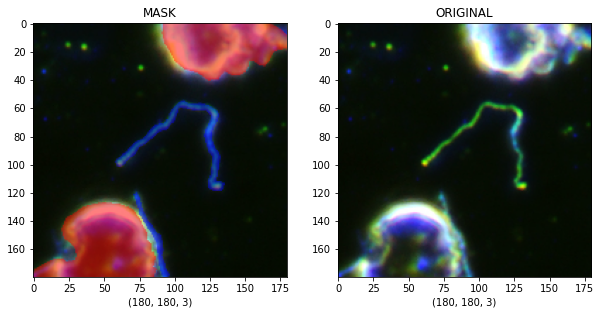

In [33]:
figure,axis = plt.subplots(1,2,figsize=(10,10))

axis[0].imshow(transform_list[10],cmap="jet")
axis[0].set_xlabel(transform_list[10].shape)
axis[0].set_title("MASK")
axis[1].imshow(im_list[10])
axis[1].set_xlabel(im_list[10].shape)
axis[1].set_title("ORIGINAL")

In [34]:
train_set = np.array(im_list, dtype="float32")
transform_set = np.array(transform_list, dtype="float32")

train_set = train_set/255
transform_set = transform_set/255



In [35]:
print(train_set.shape)
print(transform_set.shape)

(366, 180, 180, 3)
(366, 180, 180, 3)


In [36]:
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

In [40]:
C_Path = Sequential()
C_Path.add(Conv2D(20, (5,5), kernel_initializer="he_normal", use_bias = True))
C_Path.add(BatchNormalization())
C_Path.add(ReLU())

C_Path.add(Conv2D(40, (5,5), kernel_initializer="he_normal", use_bias = True))
C_Path.add(BatchNormalization())
C_Path.add(ReLU())

C_Path.add(Conv2D(80, (5,5), kernel_initializer="he_normal", use_bias = True))
C_Path.add(BatchNormalization())
C_Path.add(ReLU())

C_Path.add(Conv2D(160, (5,5), kernel_initializer="he_normal", use_bias = True))
C_Path.add(BatchNormalization())
C_Path.add(ReLU())


C_Path.add(Conv2D(210, (5,5), kernel_initializer="he_normal", use_bias = True))
C_Path.add(BatchNormalization())
C_Path.add(ReLU())


E_Path = Sequential()
E_Path.add(Conv2DTranspose(160, (5,5)))
E_Path.add(ReLU())

E_Path.add(Conv2DTranspose(80, (5,5)))
E_Path.add(ReLU())

E_Path.add(Conv2DTranspose(40, (5,5)))
E_Path.add(ReLU())

E_Path.add(Conv2DTranspose(20, (5,5)))
E_Path.add(ReLU())

E_Path.add(Conv2DTranspose(1, (5,5)))
E_Path.add(ReLU())


In [41]:
newModel = Sequential([C_Path, E_Path])
newModel.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.00001), metrics=["mse"])


In [42]:
model_fit = newModel.fit(train_set[:350], transform_set[:350], epochs=40, callbacks=[Checkpoint_Model])

Epoch 1/40
11/11 [==============================] - 19s 646ms/step - loss: 2.3137 - mse: 0.0635
Epoch 2/40
11/11 [==============================] - 4s 326ms/step - loss: 1.0999 - mse: 0.0523
Epoch 3/40
11/11 [==============================] - 4s 326ms/step - loss: 0.8935 - mse: 0.0602
Epoch 4/40
11/11 [==============================] - 4s 330ms/step - loss: 0.7408 - mse: 0.0441
Epoch 5/40
11/11 [==============================] - 4s 329ms/step - loss: 0.6742 - mse: 0.0391
Epoch 6/40
11/11 [==============================] - 4s 346ms/step - loss: 0.6257 - mse: 0.0374
Epoch 7/40
11/11 [==============================] - 4s 350ms/step - loss: 0.5917 - mse: 0.0339
Epoch 8/40
11/11 [==============================] - 4s 351ms/step - loss: 0.5664 - mse: 0.0308
Epoch 9/40
11/11 [==============================] - 4s 352ms/step - loss: 0.5486 - mse: 0.0300
Epoch 10/40
11/11 [==============================] - 4s 354ms/step - loss: 0.5337 - mse: 0.0288
Epoch 11/40
11/11 [=============================

In [52]:
preds = newModel.predict(train_set[:1])

Text(0.5, 1.0, 'PREDICTION')

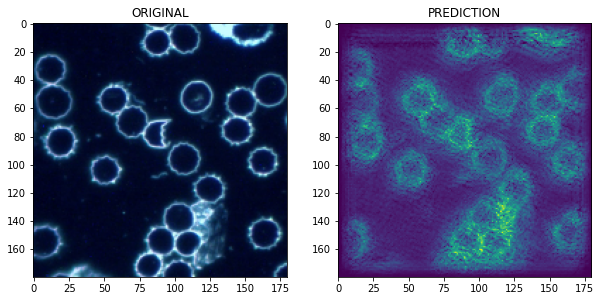

In [53]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
axis[0].imshow(train_set[0])
axis[0].set_title("ORIGINAL")
axis[1].imshow(preds[0])
axis[1].set_title("PREDICTION")